In [1]:
# !pip install ctransformers[cuda]

In [1]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from ctransformers import AutoModelForCausalLM
import pandas as pd
from sklearn.metrics import accuracy_score
import json
from tqdm import tqdm
import waiter as w
import pandas as pd
waiter = w.Waiter()

c:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


# Evaluation

In [2]:
file_path = 'dataset3.2.csv'
file_path_large = 'larger_orders.csv'

In [3]:
def preprocess_string(input_string):
    # Remove whitespaces and line breaks
    processed_string = input_string.replace(" ", "").replace("'", "\"").lower()#.replace("\n", "")
    return processed_string

In [4]:
def convert_json_to_dict(json_str):
    """
    Convert a list of JSON-formatted strings to a list of dictionaries.

    Parameters:
    - json_list (str): A JSON-formatted string representing a list of dictionaries.

    Returns:
    - list: A list of dictionaries.
    """
    dict_list = []
    try:
        json_list = f"[{json_str}]"
        dict_list = json.loads(json_list)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
    return dict_list

In [5]:
def convert_list_to_psv(order_list):
    """
    Convert a list of dictionaries to a CSV-formatted string with a pipe ('|') as the separator.

    Parameters:
    - data_list (list): A list of dictionaries.

    Returns:
    - str: A PSV-formatted string.
    """
    if not order_list:
        return ''

    # Get field names from the keys of the first dictionary in the list
    field_names = order_list[0].keys()

    # Initialize the CSV-formatted string with the header
    csv_string = '|'.join(field_names) + '\n'

    # Append data rows to the CSV string
    for data_row in order_list:
        row_values = [str(data_row[field]) for field in field_names]
        csv_string += '|'.join(row_values) + '\n'

    return csv_string

In [6]:
def read_psv_order(order_str: str):
    """
    Processes a pipe-separated values (PSV) order string to identify valid food items.

    This function iterates over each line of the input `order` string, which is expected to be in PSV format (each line contains fields separated by '|'). It splits each line into dish, quantity, and comment. Then, it uses fuzzy matching to find the most similar item from a predefined menu (`mn.mcdonalds_menu`). If the similarity score is 90% or higher, the item is considered a valid menu item and is added to the `_ordered` list with its details. Otherwise, it is added to the `_unavailable` list.

    Args:
        order (str): A string representing the order, with each line in the format of 'dish|quantity|comment'.

    Attributes Modified:
        self._ordered (list): A list of dictionaries where each dictionary contains 'dish', 'comment', and 'quantity' for confirmed menu items.
        self._unavailable (list): A list of dishes that are not found in the menu or have a similarity score below 90.
    """
    order = []
    for line in order_str.split('\n'):
        if 'dish' in line:
            continue
        if line.count('|') != 2:
            continue
        if '---' in line:
            continue
        if not line.strip():
            continue
        food_item = line.split('|')
        dish, quantity, comment = food_item
        order.append({"dish": dish, "quantity": quantity, "comment": comment})
    return order
        

In [7]:
def compare_psv_order(order_str: str,expected_str: str):
    """
    Processes a pipe-separated values (PSV) order string to identify valid food items.

    This function iterates over each line of the input `order` string, which is expected to be in PSV format (each line contains fields separated by '|'). It splits each line into dish, quantity, and comment. Then, it uses fuzzy matching to find the most similar item from a predefined menu (`mn.mcdonalds_menu`). If the similarity score is 90% or higher, the item is considered a valid menu item and is added to the `_ordered` list with its details. Otherwise, it is added to the `_unavailable` list.

    Args:
        order (str): A string representing the order, with each line in the format of 'dish|quantity|comment'.

    Attributes Modified:
        self._ordered (list): A list of dictionaries where each dictionary contains 'dish', 'comment', and 'quantity' for confirmed menu items.
        self._unavailable (list): A list of dishes that are not found in the menu or have a similarity score below 90.
    """
    order = []
    for line in order_str.split('\n'):
        if 'dish' in line:
            continue
        if line.count('|') != 2:
            continue
        if '---' in line:
            continue
        if not line.strip():
            continue
        food_item = line.split('|')
        dish, quantity, comment = food_item
        order.append({"dish": dish, "comment": comment, "quantity": quantity})
    return order
        

In [8]:
# test_dataset = pd.read_csv(file_path, nrows=20)
test_dataset = pd.read_csv(file_path)

expected_labels = test_dataset['Prompt'].tolist()
predicted_labels = [waiter.predict(w.create_prompt(prompt)) for prompt in tqdm(test_dataset['User'].tolist(), desc="Generating Predictions")]
total_correct_dishes = 0
total_correct_quantity = 0
total_correct_comment = 0
total_dishes = 0
total_quantity = 0
total_comment = 0
idx = -1
for expected_label, predicted_label in zip(expected_labels, predicted_labels):
  idx = idx + 1
  predicted_label = preprocess_string(predicted_label)
  expected_label = preprocess_string(expected_label)
  try:
    predicted_list = read_psv_order(predicted_label)
  except Exception as e:
    print(f"Error processing order: {e}")
    print("Wrong prediction is: " + predicted_label)
    continue
  expected_list = convert_json_to_dict(expected_label)
  psv_str = convert_list_to_psv(expected_list)

  pred_dish_list = []
  pred_quant_list = []
  pred_comment_list = []
  exp_dish_list = []
  exp_quant_list = []
  exp_comment_list = []
  correct_dishes = 0
  correct_quantity = 0
  correct_comment = 0
  
  if not predicted_list or not expected_list:
    print("One or both lists are empty. Cannot perform comparison.")
  else:
    for item in predicted_list:
      pred_dish_list.append(item['dish'])
      pred_quant_list.append(item['quantity'])
      pred_comment_list.append(item['comment'])
      
    for item in expected_list:
      exp_dish_list.append(item['dish'])
      exp_quant_list.append(item['quantity'])
      exp_comment_list.append(item['comment'])

    for i in range(min(len(predicted_list), len(expected_list))):
      pred_dish = pred_dish_list[i].replace("\"", "")
      pred_quant = pred_quant_list[i]
      pred_comment = pred_comment_list[i].replace("\"", "")

      exp_dish = exp_dish_list[i]
      exp_quant = str(exp_quant_list[i])
      exp_comment = exp_comment_list[i]

      if exp_dish in pred_dish:
          correct_dishes = correct_dishes + 1
      else:
          print('--------')
          print("Order made")
          print(test_dataset['User'].tolist()[idx])
          print(f'WRONG Dish Prediction: {pred_dish}, Expected Dish: {exp_dish}')
          print(f'Expected Order: {expected_list}, while predicted is: {predicted_list}')
          print('--------')
      if pred_quant == exp_quant:
          correct_quantity = correct_quantity + 1
      else:
          print('--------')
          print("Order made")
          print(test_dataset['User'].tolist()[idx])
          print(f'WRONG Quantity Prediction: {pred_quant}, Expected Quantity: {exp_quant}')
          print(f'Expected Order: {expected_list}, while predicted is: {predicted_list}')
          print('--------')

      if exp_comment in pred_comment:
          correct_comment = correct_comment + 1
      else:
          print('--------')
          print("Order made")
          print(test_dataset['User'].tolist()[idx])
          print(f'WRONG Comment Prediction: {pred_comment}, Expected Comment: {exp_comment}')
          print(f'Expected Order: {expected_list}, while predicted is: {predicted_list}')
          print('--------')
          
  total_correct_dishes = total_correct_dishes + correct_dishes
  total_correct_quantity = total_correct_quantity + correct_quantity
  total_correct_comment = total_correct_comment + correct_comment
  total_dishes = total_dishes + len(exp_dish_list)
  total_quantity = total_quantity + len(exp_quant_list)
  total_comment = total_comment + len(exp_comment_list)

precision_dishes = total_correct_dishes / total_dishes
precision_quantity = total_correct_quantity / total_quantity
precision_comment = total_correct_comment / total_comment
print('\n------------------------------------------------------------------------------')
print("Total Predictions made correct")
print(str(total_correct_dishes) + " dishes are correct out of " + str(total_dishes) + ". Percision is " + str(round(precision_dishes, 2)))
print(str(total_correct_quantity) + " quantities are correct out of " + str(total_quantity) + ". Percision is " + str(round(precision_quantity, 2)))
print(str(total_correct_comment) + " comments are correct out of " + str(total_comment) + ". Percision is " + str(round(precision_comment, 2)))

Generating Predictions: 100%|██████████| 134/134 [26:47<00:00, 11.99s/it]

--------
Order made
Give me Crispy Chicken Sandwich, no lettuce, and a medium Sprite please.
WRONG Comment Prediction: , Expected Comment: medium
Expected Order: [{'dish': 'crispychickensandwich', 'quantity': 1, 'comment': 'nolettuce'}, {'dish': 'sprite', 'quantity': 1, 'comment': 'medium'}], while predicted is: [{'dish': 'crispychickensandwich', 'quantity': '1', 'comment': 'nolettuce'}, {'dish': 'mediumsprite', 'quantity': '1', 'comment': ''}]
--------
--------
Order made
I want a Quarter Pounder with Cheese with bacon, and also please add a small Fanta.
WRONG Comment Prediction: bacon, Expected Comment: addbacon
Expected Order: [{'dish': 'quarterpounderwithcheese', 'quantity': 1, 'comment': 'addbacon'}, {'dish': 'fanta', 'quantity': 1, 'comment': 'small'}], while predicted is: [{'dish': 'quarterpounderwithcheese', 'quantity': '1', 'comment': 'bacon'}, {'dish': 'fanta', 'quantity': '1', 'comment': 'small'}]
--------
--------
Order made
Large French Fries and a Hot Apple Pie.
WRONG Com

In [10]:
# test_dataset = pd.read_csv(file_path_large, nrows=2)
test_dataset = pd.read_csv(file_path_large)

expected_labels = test_dataset['Prompt'].tolist()
predicted_labels = [waiter.predict(w.create_prompt(prompt)) for prompt in tqdm(test_dataset['User'].tolist(), desc="Generating Predictions")]
total_correct_dishes = 0
total_correct_quantity = 0
total_correct_comment = 0
total_dishes = 0
total_quantity = 0
total_comment = 0
idx = -1
for expected_label, predicted_label in zip(expected_labels, predicted_labels):
  idx = idx + 1
  predicted_label = preprocess_string(predicted_label)
  expected_label = preprocess_string(expected_label)
  try:
    predicted_list = read_psv_order(predicted_label)
  except Exception as e:
    print(f"Error processing order: {e}")
    print("Wrong prediction is: " + predicted_label)
    continue
  expected_list = convert_json_to_dict(expected_label)
  psv_str = convert_list_to_psv(expected_list)

  pred_dish_list = []
  pred_quant_list = []
  pred_comment_list = []
  exp_dish_list = []
  exp_quant_list = []
  exp_comment_list = []
  correct_dishes = 0
  correct_quantity = 0
  correct_comment = 0
  
  if not predicted_list or not expected_list:
    print("One or both lists are empty. Cannot perform comparison.")
  else:
    for item in predicted_list:
      pred_dish_list.append(item['dish'])
      try:
        quantity_as_int = int(item['quantity'])
        pred_quant_list.append(item['quantity'])
        pred_comment_list.append(item['comment'])
      except ValueError:
        comment_quantity_str = item['quantity'] + " " + item['comment']
        pred_comment_list.append(comment_quantity_str)
        
    for item in expected_list:
      exp_dish_list.append(item['dish'])
      exp_quant_list.append(item['quantity'])
      exp_comment_list.append(item['comment'])

    for i in range(min(len(predicted_list), len(expected_list))):
      pred_dish = pred_dish_list[i].replace("\"", "")
      pred_quant = pred_quant_list[i]
      pred_comment = pred_comment_list[i].replace("\"", "")

      exp_dish = exp_dish_list[i]
      exp_quant = str(exp_quant_list[i])
      exp_comment = exp_comment_list[i]

      if exp_dish in pred_dish:
          correct_dishes = correct_dishes + 1
      else:
          print('--------')
          print("Order made")
          print(test_dataset['User'].tolist()[idx])
          print(f'WRONG Dish Prediction: {pred_dish}, Expected Dish: {exp_dish}')
          print(f'Expected Order: {expected_list}, while predicted is: {predicted_list}')
          print('--------')
      if pred_quant == exp_quant:
          correct_quantity = correct_quantity + 1
      else:
          print('--------')
          print("Order made")
          print(test_dataset['User'].tolist()[idx])
          print(f'WRONG Quantity Prediction: {pred_quant}, Expected Quantity: {exp_quant}')
          print(f'Expected Order: {expected_list}, while predicted is: {predicted_list}')
          print('--------')

      if exp_comment in pred_comment:
          correct_comment = correct_comment + 1
      else:
          print('--------')
          print("Order made")
          print(test_dataset['User'].tolist()[idx])
          print(f'WRONG Comment Prediction: {pred_comment}, Expected Comment: {exp_comment}')
          print(f'Expected Order: {expected_list}, while predicted is: {predicted_list}')
          print('--------')
          
  total_correct_dishes = total_correct_dishes + correct_dishes
  total_correct_quantity = total_correct_quantity + correct_quantity
  total_correct_comment = total_correct_comment + correct_comment
  total_dishes = total_dishes + len(exp_dish_list)
  total_quantity = total_quantity + len(exp_quant_list)
  total_comment = total_comment + len(exp_comment_list)

precision_dishes = total_correct_dishes / total_dishes
precision_quantity = total_correct_quantity / total_quantity
precision_comment = total_correct_comment / total_comment
print('\n------------------------------------------------------------------------------')
print("Total Predictions made correct")
print(str(total_correct_dishes) + " dishes are correct out of " + str(total_dishes) + ". Percision is " + str(round(precision_dishes, 2)))
print(str(total_correct_quantity) + " quantities are correct out of " + str(total_quantity) + ". Percision is " + str(round(precision_quantity, 2)))
print(str(total_correct_comment) + " comments are correct out of " + str(total_comment) + ". Percision is " + str(round(precision_comment, 2)))

Generating Predictions: 100%|██████████| 16/16 [10:22<00:00, 38.89s/it]

--------
Order made
Good morning! We'd like to place an order for two Mac Toasts, a Mac Double, three Double Cheeseburgers, a Mac Snack Wrap, Plov, cream cookie, three Paneer Masalas, a Filet-O-Fish, Chicken McNuggets, and one Premium Caesar Salad. Actually, make it two Premium Caesar Salads! We'd also like three Sausage McGriddles. For dessert, we'll have five Egg McMuffins, two Hot Caramel Sundaes, and a Soft Baked Oatmeal Raisin Cookie.
WRONG Quantity Prediction: 2, Expected Quantity: 1
Expected Order: [{'dish': 'mactoast', 'quantity': 2, 'comment': ''}, {'dish': 'macdouble', 'quantity': 1, 'comment': ''}, {'dish': 'doublecheeseburger', 'quantity': 3, 'comment': ''}, {'dish': 'macsnackwrap', 'quantity': 1, 'comment': ''}, {'dish': 'plov', 'quantity': 1, 'comment': ''}, {'dish': 'creamcookie', 'quantity': 1, 'comment': ''}, {'dish': 'paneermasala', 'quantity': 3, 'comment': ''}, {'dish': 'filet-o-fish', 'quantity': 1, 'comment': ''}, {'dish': 'chickenmcnuggets', 'quantity': 1, 'comme

In [ ]:
test_dataset = pd.read_csv(file_path)

for idx, label in enumerate(predicted_labels):
    print('-----------------------')
    print("Order made")
    print(test_dataset['User'].tolist()[idx])
    print("Model Predicted")
    print(label)
    predicted_label = preprocess_string(label)
    predicted_list = read_psv_order(predicted_label)
    print("Post-processed order in json:")
    print(predicted_list)

-----------------------
Order made
A classic Big Mac with extra pickles and a large Coca-Cola.
Model Predicted


dish|quantity|comment
Big Mac|1|extra pickles
Coca-Cola|1|large

A classic Big Mac with extra pickles and a large Coca-Cola
Post-processed order in json:
[{'dish': 'bigmac', 'quantity': '1', 'comment': 'extrapickles'}, {'dish': 'coca-cola', 'quantity': '1', 'comment': 'large'}]
-----------------------
Order made
Give me Crispy Chicken Sandwich, no lettuce, and a medium Sprite please.
Model Predicted


crispy chicken sandwich|1|no lettuce
medium sprite|1|
Post-processed order in json:
[{'dish': 'crispychickensandwich', 'quantity': '1', 'comment': 'nolettuce'}, {'dish': 'mediumsprite', 'quantity': '1', 'comment': ''}]
-----------------------
Order made
I want a Quarter Pounder with Cheese with bacon, and also please add a small Fanta.
Model Predicted


dish|quantity|comment
Quarter Pounder with Cheese|1|bacon
Fanta|1|small
Post-processed order in json:
[{'dish': 'quarterpounde

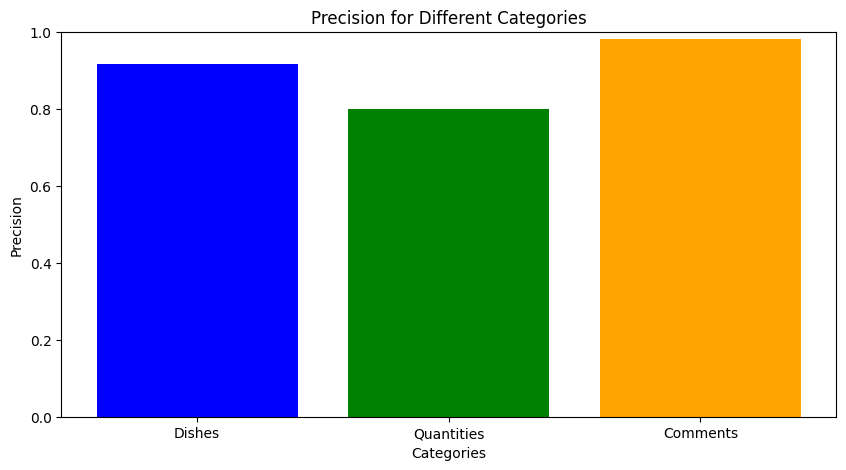

In [11]:
import matplotlib.pyplot as plt
labels = ['Dishes', 'Quantities', 'Comments']
precision_values = [precision_dishes, precision_quantity, precision_comment]

plt.figure(figsize=(10, 5))
plt.bar(labels, precision_values, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit to show precision values between 0 and 1
plt.xlabel('Categories')
plt.ylabel('Precision')
plt.title('Precision for Different Categories')
plt.show()

In [ ]:
# Calculate precision, recall, and F1 score
precision_dishes = total_correct_dishes / total_dishes
recall_dishes = total_correct_dishes / total_correct_dishes
f1_dishes = 2 * (precision_dishes * recall_dishes) / (precision_dishes + recall_dishes)

precision_quantity = total_correct_quantity / total_quantity
recall_quantity = total_correct_quantity / total_correct_quantity
f1_quantity = 2 * (precision_quantity * recall_quantity) / (precision_quantity + recall_quantity)

precision_comment = total_correct_comment / total_comment
recall_comment = total_correct_comment / total_correct_comment
f1_comment = 2 * (precision_comment * recall_comment) / (precision_comment + recall_comment)

# Display F1 score
print("\nF1 Score (Dishes):", f1_dishes)
print("F1 Score (Quantity):", f1_quantity)
print("F1 Score (Comment):", f1_comment)


F1 Score (Dishes): 0.8221709006928406
F1 Score (Quantity): 0.9008620689655172
F1 Score (Comment): 0.7621359223300971
